### Where does the scaling work or does not work?

In [3]:
import cmocean as cmo
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats 
import seaborn as sns
from netCDF4 import Dataset
import xarray as xr

import os
import sys

import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

In [4]:
# CONSTANTS AND SCALES

L = 6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Wsb = 13000 # Width at shelf break
Hs = 147.5 # Shelf break depth
s = 0.005 # shelf slope 
W = 8300 # mid-length width
Hh = 97.5 # head depth
Hr = 132.0 # rim depth at DnS
No = 5.5E-3 # Initial stratification at shelf-break depth
f = 9.66E-5 # Coriois parameter 
kv = 1E-5   # base case background vertical diffusivity
kbg = 1E-5  # base case canyon vertical diffusivity
t = 6.5 # diffusion timescale, days 
U = 0.36 # incoming velocity base case, m/s

# NOTE: The default values of all functions correspond to the base case

def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U=0.37,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N=5.5E-3,f=9.66E-5,W=8300,Hs=150.0):
    '''Burger number'''
    return(N*Hs/(f*W))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)


In [5]:
# SCALING SCHEME (WITH DIMENSIONS)

def Cbar(grad, Hs, Hr, Co):
    '''
    INPUT
    grad :float: Scaled tracer gradient [C]/m
    Hs: float: Shelf-break depth (m)
    Hr: float: Rim depth (m)
    Co: float: Initial concentration near shelf break [C]
    RETURNS 
    approx concentration of upwelled water. See equation 26 in paper 1
    '''
    return(((0.01*(grad*(Hs+Hr)/2.0))+1.0)*Co)

def dTrdz(dTr0, Hs, Zup, Zdifup, Hh):
    '''
    INPUT
    dTr0: float: Initial tracer gradient near shelf break [C]/m
    Zup: float: depth of upwelling (m)
    Zdifup: float: squeezing effect due to locally enchanced diffusivity (m)
    Hh: float: Head depth (m)
    RETURNS
    dTrdz: float: Scaled tracer gradient near canyon head. See equation 22.
    '''
    return(-dTr0*(4.17*(1+((Zup+Zdifup)/Hh))-3.25))

def PhiHA(s, N, U, f, W, L):
    '''
    INPUT
    s: float: shelf slope
    N: float: initial stratification
    U: float: incomming velocity
    W: float: Mid-length width of the canyon
    L: float: Canyon length
    f: float: Coriolis Parameter
    RETURNS
     Upwelling flux: float: as calculated by Howatt and Allen, 2013.
    '''
    Se = (s*N)/(f*((F(Ro(U,f,W))/Ro(U,f,L))**(1/2)))
    #return((U*W*Dh(f,L,N))*(0.91*((F(Ro(U,f,W))**(1.5))*(Ro(U,f,L)**(0.5))*((1-(1.21*Se))**3))+0.07))
    return((U*W*Dh(f,L,N))*(4.99*((F(Ro(U,f,W))**(1.5))*(Ro(U,f,L)**(0.5))*((1-(1.21*Se))**3))+0.004))

def PhiTr(Phi, Capprox):
    '''
    INPUT
    Phi: float: upwelling flux as calulated by Howatt adn Allen, 2013. Function PhiHA.
    Capprox: float: Approx concentration of upwelled water. Function Cbar.
    RETURNS
     Tracer flux upwelled onto the shelf: flux: Phi*Capprox.
    '''
    return(Phi*Capprox)
    
def Z(f, U, R, L, N):
    '''
    INPUT
    U: float: incomming velocity
    R: float: Radius of curvature shelf-break isobath
    f: float: Coriolis Parameter
    L: float: Canyon length
    N: float: initial stratification
    RETURNS
    Depth of upwelling from Allen and Hickey, 2010.
    '''
    return(((f*U*F(Ro(U,f,R))*L)**(0.5))/N)

def Zdif(t, kv, kbg):
    '''
    INPUT
    t : float: timescale for upwelling (sec)
    kv: float: vertical diffusivity within the canyon
    kbg: float: background vertical diffusivity
    RETURNS
    Zdif: float: squeezing effect due to locally enchanced diffusivity (m)
    '''
    return(np.sqrt(t*3600*24*(kv-kbg)))


In [6]:
lib_path = os.path.abspath('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/PythonScripts/Paper1Figures/') # Add absolute path to my python scripts
sys.path.append(lib_path)

import canyon_records 
import nocanyon_records

records = canyon_records.main()
recordsNoC = nocanyon_records.main()

import canyon_records_tracers
recordsTr = canyon_records_tracers.main()

In [7]:
# Grid, state and tracers datasets of base case
grid_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
grid = xr.open_dataset(grid_file)

state_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/stateGlob.nc' 
state = xr.open_dataset(state_file)

ptracers_file = '/data/kramosmu/results/TracerExperiments/BARKLEY/run01/ptracersGlob.nc'

ptracers_file_parab = '/data/kramosmu/results/TracerExperiments/CNTDIFF_7Tr/run01/ptracersGlob.nc'

ptracers_fileNoC = '/data/kramosmu/results/TracerExperiments/BARKLEY/run02/ptracersGlob.nc'

times = state.variables['T']
depth = grid.variables['RC']

fileBAR = ('/data/kramosmu/results/TracerExperiments/BARKLEY/HCW_TrMass_BARKLEY_run01.csv')
fileBARNoC = ('/data/kramosmu/results/TracerExperiments/BARKLEY/HCW_TrMass_BARKLEY_run02.csv') 

fileLWR = ('/data/kramosmu/results/TracerExperiments/CNTDIFF_7Tr/HCW_TrMass_CNTDIFF_7Tr_run01.csv')
fileLWRNoC = ('/data/kramosmu/results/TracerExperiments/CNTDIFF_7Tr/HCW_TrMass_CNTDIFF_7Tr_run02.csv') 

dfBAR = pd.read_csv(fileBAR)
dfBARnoc = pd.read_csv(fileBARNoC)

dfLWR = pd.read_csv(fileLWR)
dfLWRnoc = pd.read_csv(fileLWRNoC)                

In [8]:
labels_Bark = ['Lin','Sal','Oxy','Nit','Sil','Pho','NitA','Met']
colours_Bark = ['purple','blue','green','gold','orange','red','orchid','teal']

labels_Para = ['Tr1','Tr2','Tr3','Tr4','Tr5','Tr6','Tr7']
colours_Para = ['tan','0.2','beige','0.4','0.5','brown','0.7'] 
sizes_Para = [11,7,7,7,7,7,7] 

In [44]:
# Get tracer gradient and tracer concetration of all runs
#------------------------------------------------------------------------------------------------------------
keys = ['Tr_profile_tt08','Tr_profile_tt10','Tr_profile_tt12','Tr_profile_tt14','Tr_profile_tt16']
key0 = 'Tr_profile_tt00'
stname = 'DnC' # Station at downstream side of canyon

Bar_maxTr = np.empty(8)
Bar_stdTr = np.empty(8)
Bar_TrSB = np.empty(8)
Bar_Ctop = np.empty(8)

Par_maxTr = np.empty(7)
Par_stdTr = np.empty(7)
Par_TrSB = np.empty(7)
Par_Ctop = np.empty(7)

record = recordsTr[0]
ii = 0

for tracer in record.tracerList:
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/%s_profile_%s_%s.csv' 
                 % (tracer,record.name,stname))
    df = pd.read_csv(filename1)
    df_anom=(df.sub(df[key0].squeeze(),axis=0))
    maxd4 = np.mean(df[keys[0]][25:30])   
    maxd5 = np.mean(df[keys[1]][25:30])   
    maxd6 = np.mean(df[keys[2]][25:30]) 
    maxd7 = np.mean(df[keys[3]][25:30])  
    maxd8 = np.mean(df[keys[4]][25:30])  
    maxd0 = df[key0][25]
    
    
    Bar_maxTr[ii] = np.mean(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    Bar_stdTr[ii] = np.std(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    Bar_TrSB[ii] = maxd0
    Bar_Ctop[ii] = df[key0][0]
    ii=ii+1
    
record = recordsTr[1]
ii = 0
for tracer in record.tracerList:
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/%s_profile_%s_%s.csv' 
                 % (tracer,record.name,stname))
    df = pd.read_csv(filename1)
    df_anom=(df.sub(df[key0].squeeze(),axis=0))
    maxd4 = np.mean(df[keys[0]][25:30])   
    maxd5 = np.mean(df[keys[1]][25:30])   
    maxd6 = np.mean(df[keys[2]][25:30]) 
    maxd7 = np.mean(df[keys[3]][25:30])  
    maxd8 = np.mean(df[keys[4]][25:30])  
    maxd0 = df[key0][25]
   
    
    Par_maxTr[ii] = np.mean(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    Par_stdTr[ii] = np.std(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    Par_TrSB[ii] = maxd0
    Par_Ctop[ii] = df[key0][0]
    ii=ii+1

#------------------------------------------------------------------------------------------------------------
keys = ['dTrdz_tt08','dTrdz_tt10','dTrdz_tt12','dTrdz_tt14','dTrdz_tt16']
key0 = 'dTrdz_tt00'
stname = 'DnC' # Station at downstream side of canyon

Bar_dTrdz = np.empty(8)
Bar_inidTrdz = np.empty(8)
Bar_dTrdz_std = np.empty(8)
       
Par_dTrdz = np.empty(7)
Par_inidTrdz = np.empty(7)
Par_dTrdz_std = np.empty(8)

record = recordsTr[0]
ii = 0
for tracer in record.tracerList:
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTrdz_Tr%s_%s_%s.csv' 
                 %(tracer,record.name,stname))
    df = pd.read_csv(filename1)

    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])

    maxd3 = min(df_anom[keys[0]][22:26])   
    maxd4 = min(df_anom[keys[1]][22:26])   
    maxd5 = min(df_anom[keys[2]][22:26])   
    maxd6 = min(df_anom[keys[3]][22:26])   
    maxd7 = min(df_anom[keys[4]][22:26])   
    
    Bar_dTrdz[ii] = np.mean(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
    Bar_inidTrdz[ii] = df[key0][26]
    Bar_dTrdz_std[ii] = np.std(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
    ii = ii+1
    
record = recordsTr[1]
ii = 0
for tracer in record.tracerList:
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTrdz_Tr%s_%s_%s.csv' 
                 %(tracer,record.name,stname))
    df = pd.read_csv(filename1)

    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])

    maxd3 = min(df_anom[keys[0]][22:26])   
    maxd4 = min(df_anom[keys[1]][22:26])   
    maxd5 = min(df_anom[keys[2]][22:26])   
    maxd6 = min(df_anom[keys[3]][22:26])   
    maxd7 = min(df_anom[keys[4]][22:26])   
 
    Par_dTrdz[ii] = np.mean(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
    Par_inidTrdz[ii] = df[key0][26]
    Par_dTrdz_std[ii] = np.std(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
   
    ii = ii+1    

#------------------------------------------------------------------------------------------------------------
keys = ['dTrdz_tt08','dTrdz_tt10','dTrdz_tt12','dTrdz_tt14','dTrdz_tt16']
key0 = 'dTrdz_tt00'
stname = 'DnC' # Station at downstream side of canyon


for record in records:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTr1dz_%s_%s.csv' %
                 (record.name,stname))
    df = pd.read_csv(filename1)
    
    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])
        
    maxd3 = min(df_anom[keys[0]][22:26])   
    maxd4 = min(df_anom[keys[1]][22:26])   
    maxd5 = min(df_anom[keys[2]][22:26])   
    maxd6 = min(df_anom[keys[3]][22:26])   
    maxd7 = min(df_anom[keys[4]][22:26])   
    
 
    record.maxdTrdz = np.mean(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
    record.stddTrdz = np.std(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
    record.inidTrdz = df[key0][26]

keys = ['Tr_profile_tt08','Tr_profile_tt10','Tr_profile_tt12','Tr_profile_tt14','Tr_profile_tt16']
key0 = 'Tr_profile_tt00'
stname = 'DnC' # Station at downstream side of canyon

for record in records:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/Tr1_profile_%s_%s.csv' % (record.name,stname))
    df = pd.read_csv(filename1)
    df_anom=(df.sub(df[key0].squeeze(),axis=0))
    maxd4 = np.mean(df[keys[0]][25:32])   
    maxd5 = np.mean(df[keys[1]][25:32])   
    maxd6 = np.mean(df[keys[2]][25:32]) 
    maxd7 = np.mean(df[keys[3]][25:32])  
    maxd8 = np.mean(df[keys[4]][25:32])  
      
    record.TrSB = df[key0][26]
    record.maxTr = np.mean(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    record.stdTr = np.std(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    
    


In [10]:
select_rec = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]

for ind in select_rec:
    file = ('/data/kramosmu/results/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(records[ind].exp_code,
                                                                                records[ind].exp_code,
                                                                                records[ind].run_num))
    fileNoC = ('/data/kramosmu/results/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].run_num))
    dfcan = pd.read_csv(file)
    dfnoc = pd.read_csv(fileNoC)
   
    records[ind].TrMass = dfcan['TrMassHCW']
    records[ind].HCW = dfcan['HCW']
    
    recordsNoC[ind].TrMass = dfnoc['TrMassHCW']
    recordsNoC[ind].HCW = dfnoc['HCW']

In [11]:
Mass_Bark = ['TrMassHCW01','TrMassHCW02','TrMassHCW03','TrMassHCW04',
             'TrMassHCW05','TrMassHCW06','TrMassHCW07','TrMassHCW08']
Mass_Para = ['TrMassHCW01','TrMassHCW02','TrMassHCW03','TrMassHCW04',
             'TrMassHCW05','TrMassHCW06','TrMassHCW07']

In [12]:
def scale_PhiTr(dTr0, Cini, Hs, f, U, R, L, N, t, kv, kbg, Hh, Hr, W ):
    ''''''
    dTr_scaled = dTrdz(dTr0, Hs, Z(f, U, R, L, N), Zdif(t, kv, kbg), Hh)
    Capprox = Cbar(dTr_scaled, Hs, Hr, Cini)
    HA = PhiHA(s, N, U, f, W, L)
    return(PhiTr(HA,Capprox), Capprox)

def model_PhiTr(mass_can_eff, time):
    ''''''
    PhiTracer = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    PhiTr_std = np.std(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    return(PhiTracer, PhiTr_std)

def model_Phi(hcw_can_eff, time):
    ''''''
    Phi = np.mean(np.array([(hcw_can_eff[ii]-hcw_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    Phi_std = np.std(np.array([(hcw_can_eff[ii]-hcw_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    return(Phi, Phi_std)

Tracer	Phi err (%)	C err (%)	dTr0		 TrSB
Tr1 	3.8		14.7		0.050		13.6
Tr2 	1.0		10.3		0.059		13.6
Tr3 	3.3		13.9		0.051		13.6
Tr4 	4.3		15.4		0.049		13.6
Tr5 	6.6		18.9		0.043		13.6
Tr6 	11.5		6.3		0.113		13.6
Tr7 	14.0		1.5		-0.013		150.1
Lin 	5.4		0.7		0.002		32.2
Sal 	5.2		0.5		0.001		33.9
Oxy 	87.4		87.6		-0.186		104.1
Nit 	18.6		12.1		0.031		32.6
Sil 	26.5		18.6		0.047		47.6
Pho 	4.4		1.2		0.001		2.2
NitA 	12.5		6.2		0.007		27.7
Met 	115.2		94.9		0.375		17.5


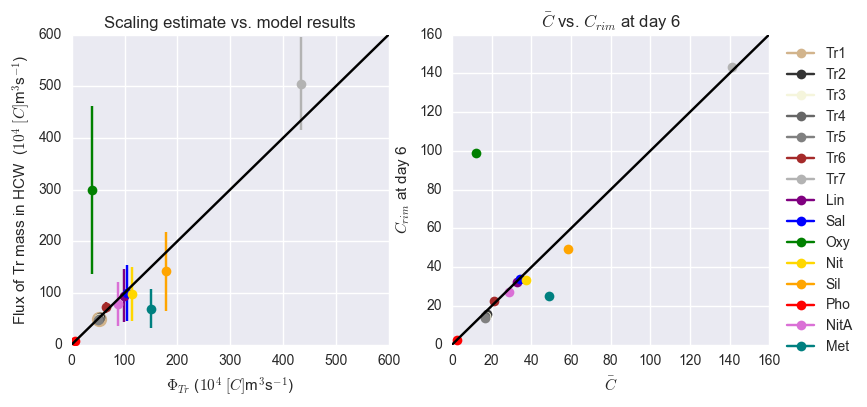

In [11]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(9,4))

print ("\t".join(['Tracer', 'Phi err (%)', 'C err (%)', 'dTr0', '\t TrSB']))

rec = recordsTr[0]

for TrMass, dTr0,Co,C, lab, col, ms in zip(Mass_Para,Par_inidTrdz[:],Par_TrSB[:],Par_maxTr[:],labels_Para,colours_Para,
                                           sizes_Para):
    scaPhiTr, CC = scale_PhiTr(dTr0, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    modPhiTr, modPhiTr_std = model_PhiTr(dfLWR[TrMass], times)
    
    ax1.errorbar(scaPhiTr/1E4, modPhiTr/1E4, yerr=modPhiTr_std/1E4, color=col, label=lab, marker='o',markersize=ms)
    err_phi = scaPhiTr/modPhiTr
    ax2.plot(CC, C, color=col, label=lab, marker='o')
    err_C = CC/C
    
    print ("%s" % (lab), "\t".join(['\t%1.1f\t\t%1.1f\t\t%1.3f\t\t%1.1f' % (abs(1-err_phi)*100, abs(1-err_C)*100, -dTr0, Co)]))
    

for TrMass, dTr0, Co,C, lab, col in zip(Mass_Bark,Bar_inidTrdz,Bar_TrSB,Bar_maxTr,labels_Bark,colours_Bark):
    
    scaPhiTr, CC = scale_PhiTr(dTr0, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    modPhiTr, PhiTr_std = model_PhiTr(dfBAR[TrMass], times)
    
    ax1.errorbar(scaPhiTr/1E4, modPhiTr/1E4, yerr=PhiTr_std/1E4, color=col, label=lab, marker='o')
    err_phi = scaPhiTr/modPhiTr
    ax2.plot(CC, C, color=col, label=lab, marker='o')
    err_C = CC/C

    print ("%s" % (lab), "\t".join(['\t%1.1f\t\t%1.1f\t\t%1.3f\t\t%1.1f' % (abs(1-err_phi)*100,
                                                                            abs(1-err_C)*100,
                                                                            -dTr0,
                                                                            Co)]))
   
 
ax1.set_xlabel(r'$\Phi_{Tr}$ ($10^4$ $[C]$m$^{3}$s$^{-1}$)')
ax1.set_ylabel('Flux of Tr mass in HCW  ($10^4$ $[C]$m$^{3}$s$^{-1}$)')
ax1.set_title('Scaling estimate vs. model results')
ax1.plot(np.linspace(0,600,50),np.linspace(0,600,50),'-k')

ax2.legend(bbox_to_anchor=(1.3,1),ncol=1, columnspacing=0.1)
ax2.set_xlabel(r'$\bar{C}$')
ax2.set_ylabel('$C_{rim}$ at day 6')
ax2.set_title(r'$\bar{C}$ vs. $C_{rim}$ at day 6')
ax2.plot(np.linspace(0,160,50),np.linspace(0,160,50),'-k')

Tracer	Phi err (%)	C err (%)	dTr0		 TrSB		 HCW err
Base 	11.3		2.2		0.036		7.2	20.1
higher\_Kbg 	1.1		1.3		0.036		7.2	17.9
highest\_Kbg 	27.0		2.9		0.036		7.2	28.7
higher\_N 	2.7		2.1		0.036		7.2	9.0
highest\_N 	83.5		1.1		0.036		7.2	61.9
lower\_N 	38.5		2.2		0.036		7.2	43.9
higher\_f 	13.0		2.4		0.036		7.2	21.4
low\_f 	8.3		0.5		0.036		7.2	19.5
lower\_f 	10.0		1.3		0.036		7.2	20.2
lowest\_f 	15.6		0.8		0.036		7.2	1.3
highestKc\_lowKbg 	11.6		4.3		0.036		7.2	20.6
higherKc\_lowKbg 	4.2		0.1		0.036		7.2	13.7
higher\_Kc 	3.0		0.1		0.036		7.2	13.5
high\_Kc 	10.9		4.4		0.036		7.2	20.7
high2\_Kc 	18.4		5.3		0.036		7.2	28.0
highest\_Kc 	17.0		2.9		0.036		7.2	28.8
low\_U 	6.8		2.0		0.036		7.2	15.9
lower\_U 	15.8		0.5		0.036		7.2	4.8
lowest\_U 	593.2		4.2		0.036		7.2	556.2
lowestU\_lowestN 	92.3		3.1		0.036		7.2	81.0
lowestU\_highestN 	11861.8		5.4		0.036		7.2	11947.6
lowestU\_lowestf 	627.6		5.4		0.036		7.2	573.8
lowestU\_highestKbg 	32.9		1.2		0.036		7.2	36.4


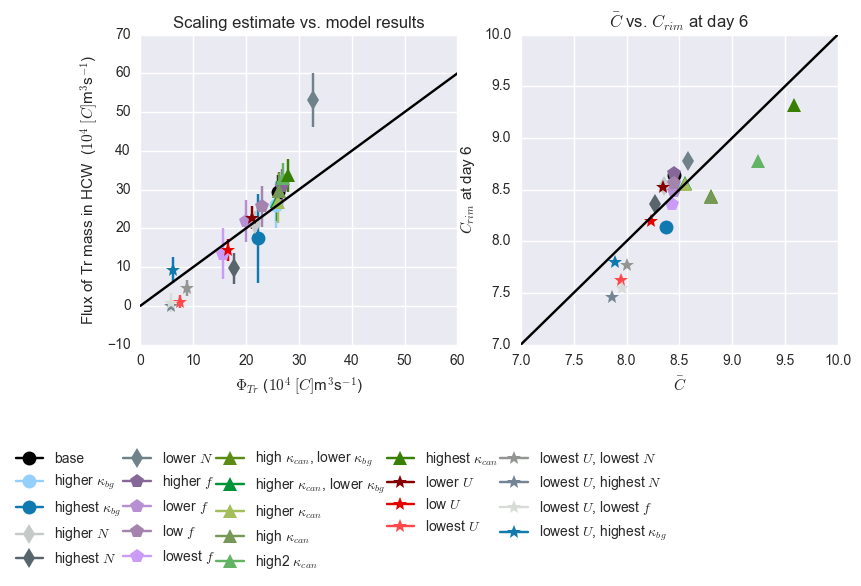

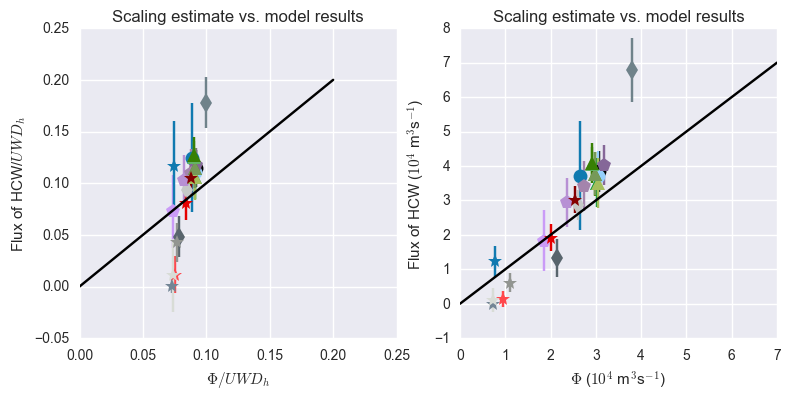

In [12]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(9,4))

fig2,[ax3,ax4] = plt.subplots(1,2,figsize=(9,4))

print ("\t".join(['Tracer', 'Phi err (%)', 'C err (%)', 'dTr0', '\t TrSB', '\t HCW err']))

for rec,recNoC in zip(records,recordsNoC):    
    
    modPhiTr, modPhiTr_std = model_PhiTr(rec.TrMass, times)
    modPhi, modPhi_std = model_Phi(rec.HCW, times)
    
    scaPhiTr, CC = scale_PhiTr(rec.inidTrdz, rec.TrSB, Hs, rec.f, rec.u_mod, R, L, rec.N, t, rec.kv, rec.kbg, Hh, Hr, W )
    scaPhi = PhiHA(s, rec.N, rec.u_mod, rec.f, W, L) 
    
    ax1.errorbar(scaPhiTr/1E4, modPhiTr/1E4, yerr=modPhiTr_std/1E4, 
                 color=sns.xkcd_rgb[rec.color2],
                 label=rec.label,
                 marker=rec.mstyle, markersize = 10)
    
    ax3.errorbar(scaPhi/(rec.u_mod*W*Dh(rec.f,L,rec.N)), modPhi/(rec.u_mod*W*Dh(rec.f,L,rec.N)), yerr=modPhi_std/(rec.u_mod*W*Dh(rec.f,L,rec.N)), 
                 color=sns.xkcd_rgb[rec.color2],
                 label=rec.label,
                 marker=rec.mstyle, markersize = 10)
    
    ax4.errorbar(scaPhi/1E4, modPhi/1E4, yerr=modPhi_std/1E4, 
                 color=sns.xkcd_rgb[rec.color2],
                 label=rec.label,
                 marker=rec.mstyle, markersize = 10)
    
    err_phi = scaPhiTr/modPhiTr
    err_phiHA = scaPhi/modPhi
    
    C = rec.maxTr
    ax2.plot(CC, C, color=sns.xkcd_rgb[rec.color2],
             label=rec.label,
             marker=rec.mstyle, markersize = 10)
    err_C = CC/C
    
    print ("%s" % (rec.paperName), "\t".join(['\t%1.1f\t\t%1.1f\t\t%1.3f\t\t%1.1f\t%1.1f' % (abs(1-err_phi)*100, 
                                                                                     abs(1-err_C)*100,
                                                                                     -rec.inidTrdz,
                                                                                     rec.TrSB, 
                                                                                      abs(1-err_phiHA)*100,  )]))
   
ax1.set_xlabel(r'$\Phi_{Tr}$ ($10^4$ $[C]$m$^{3}$s$^{-1}$)')
ax1.set_ylabel('Flux of Tr mass in HCW  ($10^4$ $[C]$m$^{3}$s$^{-1}$)')
ax1.set_title('Scaling estimate vs. model results')
ax1.plot(np.linspace(0,60,50),np.linspace(0,60,50),'-k')

ax2.legend(bbox_to_anchor=(0.5,-0.3),ncol=5, columnspacing=0.1)
ax2.set_xlabel(r'$\bar{C}$')
ax2.set_ylabel('$C_{rim}$ at day 6')
ax2.set_title(r'$\bar{C}$ vs. $C_{rim}$ at day 6')
ax2.plot(np.linspace(7,10,30),np.linspace(7,10,30),'-k')    

ax3.set_xlabel(r'$\Phi/UWD_h$')
ax3.set_ylabel('Flux of HCW/$UWD_h$')
ax3.set_title('Scaling estimate vs. model results')
ax3.plot(np.linspace(0,0.2,50),np.linspace(0,0.2,50),'-k')

ax4.set_xlabel(r'$\Phi$ ($10^4$ m$^3$s$^{-1}$)')
ax4.set_ylabel('Flux of HCW ($10^4$ m$^3$s$^{-1}$)')
ax4.set_title('Scaling estimate vs. model results')
ax4.plot(np.linspace(0,7,50),np.linspace(0,7,50),'-k')


Model vs scaling comparison changes a lot if I average over days 4-8 or over days 4-9. I kept the 4-8 because it has smaller standard deviations which means that the fluxes are a bit more consistent. I also tried calcluating U as Tara did  (see rec.u_ha instead of rec.u_mod) but it is very sismilar to how I did it. She averaged over a bit shallower profiles instead of a box. I'm not sure if the average was over the entire run or over the advective phase but I assume the latter one.

Also, the non-dimensional plot looks very similar to the bottom end of the one in H&A 2013 even if it sems like the scaling is not working here.

I will fit the model results to the scaling and try to find the best values for the coefficients (originally, in H&A 2013 they are 0.91 and 0.07).

### Non-dimensional form

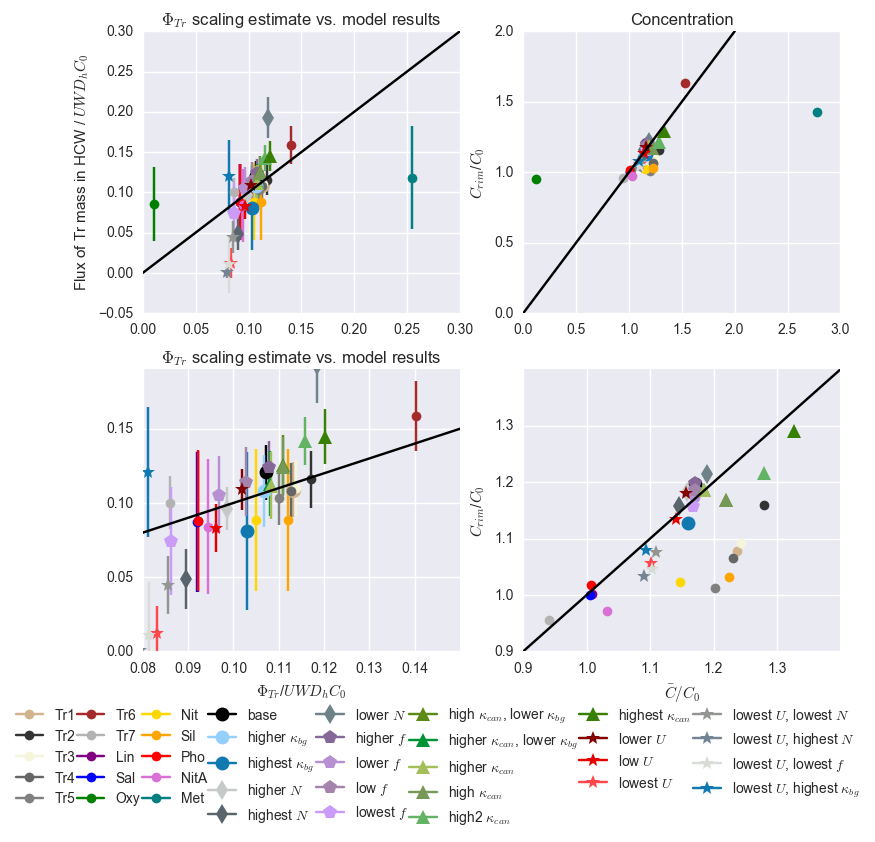

In [13]:
fig,([ax1,ax2],[ax3,ax4]) = plt.subplots(2,2,figsize=(9,8))


for TrMass, dTr0,Co,C, lab, col, ms in zip(Mass_Para,Par_inidTrdz[:],Par_TrSB[:],Par_maxTr[:],labels_Para,colours_Para,
                                           sizes_Para):
    scaPhiTr, CC = scale_PhiTr(dTr0, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    modPhiTr, modPhiTr_std = model_PhiTr(dfLWR[TrMass], times)
    
    ax1.errorbar(scaPhiTr/(U*W*Dh(f,L,No)*Co), modPhiTr/(U*W*Dh(f,L,No)*Co),
                 yerr=modPhiTr_std/(U*W*Dh(f,L,No)*Co), 
                 color=col, label=lab, marker='o',markersize=ms)
    ax3.errorbar(scaPhiTr/(U*W*Dh(f,L,No)*Co), modPhiTr/(U*W*Dh(f,L,No)*Co),
                 yerr=modPhiTr_std/(U*W*Dh(f,L,No)*Co), 
                 color=col, label=lab, marker='o',markersize=ms)
    err_phi = scaPhiTr/modPhiTr
    ax2.plot(CC/Co, C/Co, color=col, label=lab, marker='o')
    ax4.plot(CC/Co, C/Co, color=col, label=lab, marker='o')
    
    err_C = CC/C
    
    
for TrMass, dTr0, Co,C, lab, col in zip(Mass_Bark,Bar_inidTrdz,Bar_TrSB,Bar_maxTr,labels_Bark,colours_Bark):
    
    scaPhiTr, CC = scale_PhiTr(dTr0, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    modPhiTr, PhiTr_std = model_PhiTr(dfBAR[TrMass], times)
    
    ax1.errorbar(scaPhiTr/(U*W*Dh(f,L,No)*Co), modPhiTr/(U*W*Dh(f,L,No)*Co), yerr=PhiTr_std/(U*W*Dh(f,L,No)*Co),
                 color=col, label=lab, marker='o')
    ax3.errorbar(scaPhiTr/(U*W*Dh(f,L,No)*Co), modPhiTr/(U*W*Dh(f,L,No)*Co), yerr=PhiTr_std/(U*W*Dh(f,L,No)*Co),
                 color=col, label=lab, marker='o')
    
    err_phi = scaPhiTr/modPhiTr
    ax2.plot(CC/Co, C/Co, color=col, label=lab, marker='o')
    ax4.plot(CC/Co, C/Co, color=col, label=lab, marker='o')
    
    err_C = CC/C

    
for rec,recNoC in zip(records,recordsNoC):    
    
    modPhiTr, modPhiTr_std = model_PhiTr(rec.TrMass, times)
    scaPhiTr, CC = scale_PhiTr(rec.inidTrdz, rec.TrSB, Hs, rec.f, rec.u_mod, R, L, rec.N, t, rec.kv, rec.kbg, Hh, Hr, W )
     
    ax1.errorbar(scaPhiTr/(rec.u_mod*W*Dh(rec.f,L,rec.N)*rec.TrSB), modPhiTr/(rec.u_mod*W*Dh(rec.f,L,rec.N)*rec.TrSB),
                 yerr=modPhiTr_std/(rec.u_mod*W*Dh(rec.f,L,rec.N)*rec.TrSB), 
                 color=sns.xkcd_rgb[rec.color2],
                 label=rec.label,
                 marker=rec.mstyle, markersize = 10)
    
    err_phi = scaPhiTr/modPhiTr
    C = rec.maxTr
    ax2.plot(CC/rec.TrSB, C/rec.TrSB, color=sns.xkcd_rgb[rec.color2],
             label=rec.label,
             marker=rec.mstyle, markersize = 10)
    err_C = CC/C
    
    ax3.errorbar(scaPhiTr/(rec.u_mod*W*Dh(rec.f,L,rec.N)*rec.TrSB), modPhiTr/(rec.u_mod*W*Dh(rec.f,L,rec.N)*rec.TrSB),
                 yerr=modPhiTr_std/(rec.u_mod*W*Dh(rec.f,L,rec.N)*rec.TrSB), 
                 color=sns.xkcd_rgb[rec.color2],
                 label=rec.label,
                 marker=rec.mstyle, markersize = 10)
    
    ax4.plot(CC/rec.TrSB, C/rec.TrSB, color=sns.xkcd_rgb[rec.color2],
             label=rec.label,
             marker=rec.mstyle, markersize = 10)
   
    
ax1.set_ylabel('Flux of Tr mass in HCW / $UWD_hC_0$')
ax1.set_title('$\Phi_{Tr}$ scaling estimate vs. model results')
ax1.plot(np.linspace(0,0.3,50),np.linspace(0,0.3,50),'-k')

ax2.set_ylabel('$C_{rim}$/$C_0$')
ax2.set_title(r'Concentration')
ax2.plot(np.linspace(0,2,50),np.linspace(0,2,50),'-k')

ax3.set_xlabel(r'$\Phi_{Tr}$/$UWD_hC_0$')
ax3.set_title('$\Phi_{Tr}$ scaling estimate vs. model results')
ax3.plot(np.linspace(0,0.3,50),np.linspace(0,0.3,50),'-k')
ax3.set_xlim(0.08,0.15)
ax3.set_ylim(0.0,0.19)

ax4.legend(bbox_to_anchor=(1.1,-0.15),ncol=8, columnspacing=0.1)
ax4.set_xlabel(r'$\bar{C}/C_0$')
ax4.set_ylabel('$C_{rim}$/$C_0$')
ax4.set_xlim(0.9,1.4)
ax4.set_ylim(0.9,1.4)

ax4.plot(np.linspace(0,2,50),np.linspace(0,2,50),'-k')

It is not working for low U runs and highest N and lowest N run...


Things to check:
* U of slower runs and all U's - fixed below
* N of high/low N runs, OK below
* HCW and Tr Mass calculation, OK below
* Scaling formulas - OK, vs papers
* Scaling restrictions - OK, notebook 
* Fit $\Phi$ scaling to model results

### U of slower runs

Pfff, not all runs within the same experiment have the same incomming U as I assumed they would. I modified records canyon and no canyon so that each run has its corresponding U as calclulated on [this notebook](http://nbviewer.jupyter.org/urls/bitbucket.org/canyonsubc/outputanalysisnotebooks/raw/tip/forcing_fixed_BC/Incoming_U_all_runs.ipynb). The attribute name is u_mod. The old u's are still there under rec.u. The plot above has the corrected values of u.

### N of high/low N runs

Make sure I have the stratification I think I'm putting in... all looks good.


In [14]:
# Save mean maximum N of days 3-6 and std for each run.

key0 = 'N2_tt00'
stname = 'DnC' # Station at downstream side of canyon

for rec in records:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/N2_%s_%s.csv' %
                 (rec.name,stname))
    df = pd.read_csv(filename1)
    
    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])
    
    rec.N_mod = df_anom[key0][28]
    
    print(r'%s : N0 = %0.4f $s^{-1}$ ' % (rec.paperName, (rec.N_mod**(0.5))))

Base : N0 = 0.0055 $s^{-1}$ 
higher\_Kbg : N0 = 0.0055 $s^{-1}$ 
highest\_Kbg : N0 = 0.0055 $s^{-1}$ 
higher\_N : N0 = 0.0063 $s^{-1}$ 
highest\_N : N0 = 0.0074 $s^{-1}$ 
lower\_N : N0 = 0.0046 $s^{-1}$ 
higher\_f : N0 = 0.0055 $s^{-1}$ 
low\_f : N0 = 0.0055 $s^{-1}$ 
lower\_f : N0 = 0.0055 $s^{-1}$ 
lowest\_f : N0 = 0.0055 $s^{-1}$ 
highestKc\_lowKbg : N0 = 0.0055 $s^{-1}$ 
higherKc\_lowKbg : N0 = 0.0055 $s^{-1}$ 
higher\_Kc : N0 = 0.0055 $s^{-1}$ 
high\_Kc : N0 = 0.0055 $s^{-1}$ 
high2\_Kc : N0 = 0.0055 $s^{-1}$ 
highest\_Kc : N0 = 0.0055 $s^{-1}$ 
low\_U : N0 = 0.0055 $s^{-1}$ 
lower\_U : N0 = 0.0055 $s^{-1}$ 
lowest\_U : N0 = 0.0055 $s^{-1}$ 
lowestU\_lowestN : N0 = 0.0046 $s^{-1}$ 
lowestU\_highestN : N0 = 0.0074 $s^{-1}$ 
lowestU\_lowestf : N0 = 0.0055 $s^{-1}$ 
lowestU\_highestKbg : N0 = 0.0055 $s^{-1}$ 


### Check HCW and TrMass calculation 

Everything looks normal and reasonable

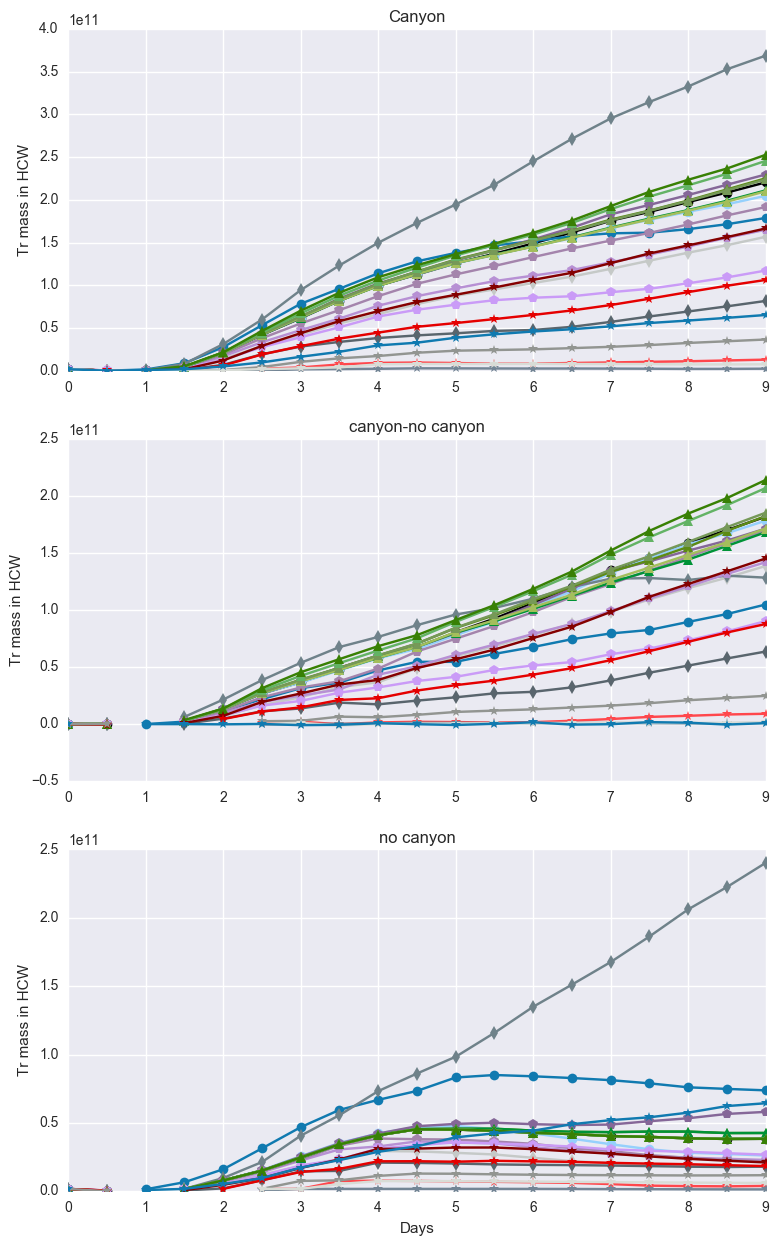

In [15]:
fig,(ax1,ax2, ax3) = plt.subplots(3,1,figsize=(9,15))

for rec,recNoC in zip(records,recordsNoC):    
    ax1.plot(times[:]/(3600*24), rec.TrMass, color=sns.xkcd_rgb[rec.color2],label=rec.label,marker=rec.mstyle)
    ax2.plot(times[:]/(3600*24), rec.TrMass-recNoC.TrMass, color=sns.xkcd_rgb[rec.color2],
             label=rec.label,marker=rec.mstyle)
    ax3.plot(times[:]/(3600*24), recNoC.TrMass, color=sns.xkcd_rgb[rec.color2],label=rec.label,marker=rec.mstyle)
    
ax1.set_ylabel('Tr mass in HCW')
ax3.set_xlabel('Days')
ax2.set_ylabel('Tr mass in HCW')
ax3.set_ylabel('Tr mass in HCW')
ax1.set_title('Canyon')
ax2.set_title('canyon-no canyon')
ax3.set_title('no canyon')

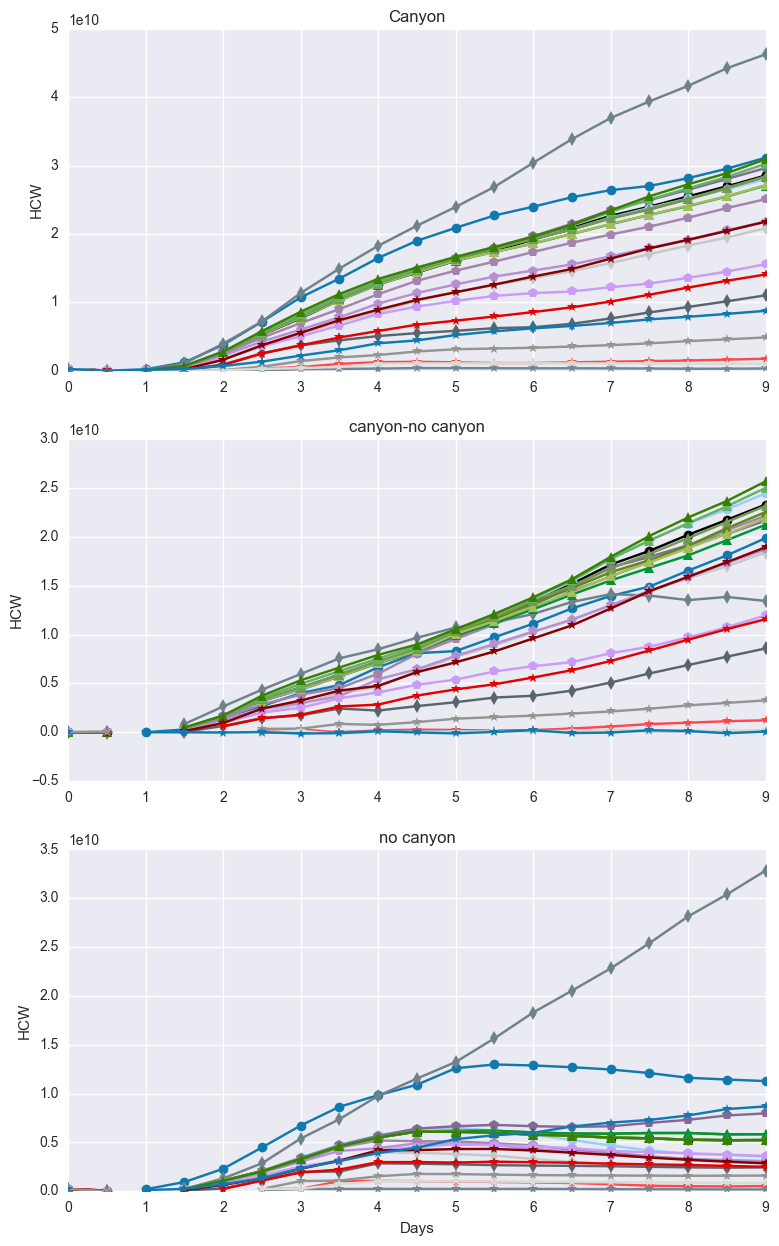

In [16]:
fig,(ax1,ax2, ax3) = plt.subplots(3,1,figsize=(9,15))

for rec,recNoC in zip(records,recordsNoC):    
    ax1.plot(times[:]/(3600*24), rec.HCW, color=sns.xkcd_rgb[rec.color2],label=rec.label,marker=rec.mstyle)
    ax2.plot(times[:]/(3600*24), rec.HCW-recNoC.HCW, color=sns.xkcd_rgb[rec.color2],
             label=rec.label,marker=rec.mstyle)
    ax3.plot(times[:]/(3600*24), recNoC.HCW, color=sns.xkcd_rgb[rec.color2],label=rec.label,marker=rec.mstyle)
    
ax1.set_ylabel('HCW')
ax3.set_xlabel('Days')
ax2.set_ylabel('HCW')
ax3.set_ylabel('HCW')
ax1.set_title('Canyon')
ax2.set_title('canyon-no canyon')
ax3.set_title('no canyon')

### Fitting $\Phi$

slope=4.99, intercept = 0.004


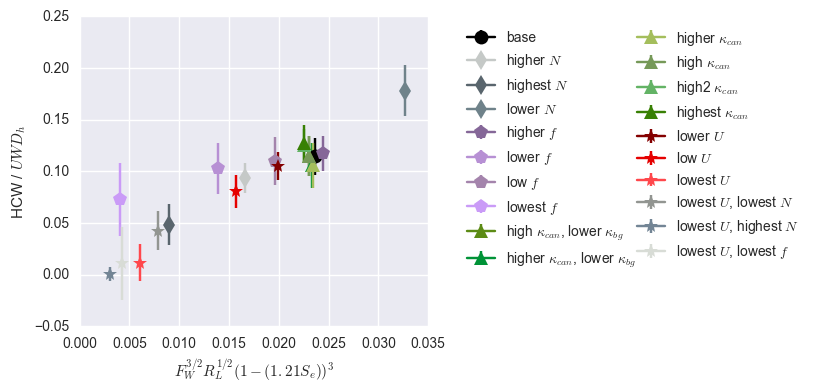

In [61]:
ind = [0,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]

records2 = []
for ii in ind:
    records2.append(records[ii])

fig,ax3 = plt.subplots(1,1,figsize=(4.5,4))

x_array = np.empty(1)
y_array = np.empty(1)

for rec in records2:    
    
    modPhi, modPhi_std = model_Phi(rec.HCW, times)
    
    Se = (s*rec.N)/(rec.f*((F(Ro(rec.u_mod,rec.f,W))/Ro(rec.u_mod,rec.f,L))**(1/2)))
    YY = ((F(Ro(rec.u_mod,rec.f,W))**(1.5))*(Ro(rec.u_mod,rec.f,L)**(0.5))*((1-(1.21*Se))**3))

    ax3.errorbar(YY, modPhi/(rec.u_mod*W*Dh(rec.f,L,rec.N)), yerr=modPhi_std/(rec.u_mod*W*Dh(rec.f,L,rec.N)), 
                 color=sns.xkcd_rgb[rec.color2],
                 label=rec.label,
                 marker=rec.mstyle, markersize = 10)
    
    err_phiHA = YY/(modPhi/(rec.u_mod*W*Dh(rec.f,L,rec.N)))
  
    x_array = np.append(x_array, np.array(modPhi/(rec.u_mod*W*Dh(rec.f,L,rec.N))))
    y_array = np.append(y_array, YY)                                                                                         
                                                                                  
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_array,x_array)

print('slope=%1.2f, intercept = %1.3f' %(slope, intercept))

ax3.set_xlabel('$F_W^{3/2}R_L^{1/2}(1-(1.21S_e))^3$')
ax3.set_ylabel('HCW / $UWD_h$')
ax3.legend(bbox_to_anchor=(2.1,1),ncol=2, columnspacing=0.1)

Tracer	Phi err (%)	Scaled Phi	Model Phi
Base 	6.8 	41077.8 	38476.0
higher\_Kbg 	9.1 	40379.9 	37026.7
highest\_Kbg 	13.6 	32140.4 	37203.5
higher\_N 	6.7 	26682.5 	28584.0
highest\_N 	2.0 	13460.1 	13195.9
lower\_N 	5.9 	63825.7 	67822.7
higher\_f 	7.6 	43400.6 	40327.3
low\_f 	28.2 	21157.1 	29479.0
lower\_f 	7.1 	31758.2 	34192.9
lowest\_f 	66.1 	6190.2 	18264.9
highestKc\_lowKbg 	4.3 	39226.2 	37618.6
higherKc\_lowKbg 	14.4 	40148.3 	35109.5
higher\_Kc 	14.9 	40379.9 	35158.8
high\_Kc 	4.1 	39226.2 	37690.8
high2\_Kc 	7.1 	37631.4 	40494.7
highest\_Kc 	8.0 	37631.4 	40913.2
low\_U 	1.2 	29832.4 	30188.8
lower\_U 	2.9 	19750.9 	19202.0
lowest\_U 	200.7 	4326.0 	1438.8
lowestU\_lowestN 	1.8 	6242.3 	6132.5
lowestU\_highestN 	3128.9 	1961.0 	60.7
lowestU\_lowestf 	132.7 	2501.4 	1074.8
lowestU\_highestKbg 	76.6 	2871.4 	12296.4


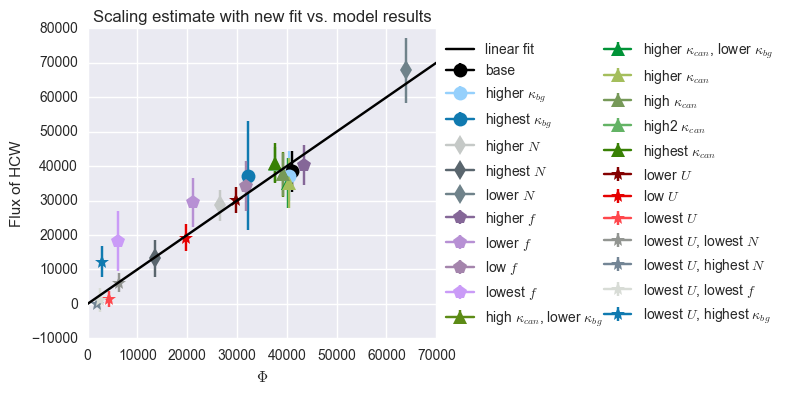

In [62]:
fig,ax3 = plt.subplots(1,1,figsize=(4.5,4))

print ("\t".join(['Tracer', 'Phi err (%)','Scaled Phi', 'Model Phi']))

x_array = np.empty(1)
y_array = np.empty(1)

for rec,recNoC in zip(records,recordsNoC):    
    
    modPhi, modPhi_std = model_Phi(rec.HCW, times)
    
    Se = (s*rec.N)/(rec.f*((F(Ro(rec.u_mod,rec.f,W))/Ro(rec.u_mod,rec.f,L))**(1/2)))
    YY = ((F(Ro(rec.u_mod,rec.f,W))**(1.5))*(Ro(rec.u_mod,rec.f,L)**(0.5))*((1-(1.21*Se))**3))
    scaPhi = slope*YY+intercept
    ax3.errorbar(scaPhi*rec.u_mod*W*Dh(rec.f,L,rec.N), modPhi, yerr=modPhi_std, 
                 color=sns.xkcd_rgb[rec.color2],
                 label=rec.label,
                 marker=rec.mstyle, markersize = 10)
    
    err_phiHA = abs((scaPhi*rec.u_mod*W*Dh(rec.f,L,rec.N))-modPhi)/(modPhi)
    
    print ("%s" % (rec.paperName), "\t".join(['\t%1.1f \t%1.1f \t%1.1f' % (err_phiHA*100,
                                                                           scaPhi*rec.u_mod*W*Dh(rec.f,L,rec.N),
                                                                           modPhi)]))
   

plt3 = ax3.plot(np.linspace(0,70000,50),np.linspace(0,70000,50),'-k',label='linear fit')

ax3.set_xlabel(r'$\Phi$')
ax3.set_ylabel('Flux of HCW')
ax3.set_title('Scaling estimate with new fit vs. model results')

ax3.legend(bbox_to_anchor=(2,1),ncol=2, columnspacing=0.1)

Fitting to HCW from the model, I get a slope of 4.99 (vs. 0.91 from H&A2013) and an intercept of 0.004 (vs 0.07 from H&A2013)

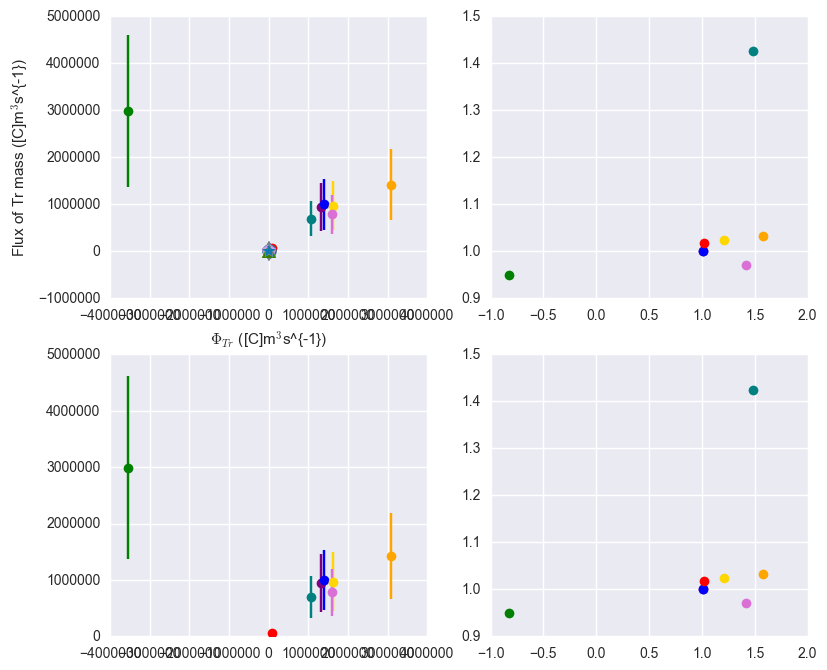

In [23]:
fig,([ax1,ax2],[ax3,ax4]) = plt.subplots(2,2,figsize=(9,8))


for TrMass, dTr0, Co,C, lab, col in zip(Mass_Bark,Bar_inidTrdz,Bar_TrSB,Bar_maxTr,labels_Bark,colours_Bark):
    
    scaPhiTr, CC = scale_PhiTr(dTr0, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    modPhiTr, PhiTr_std = model_PhiTr(dfBAR[TrMass], times)
    
    ax1.errorbar(scaPhiTr, modPhiTr, yerr=PhiTr_std,
                 color=col, label=lab, marker='o')
    ax3.errorbar(scaPhiTr, modPhiTr, yerr=PhiTr_std,
                 color=col, label=lab, marker='o')
    
    err_phi = scaPhiTr/modPhiTr
    ax2.plot(CC/Co, C/Co, color=col, label=lab, marker='o')
    ax4.plot(CC/Co, C/Co, color=col, label=lab, marker='o')
    
    err_C = CC/C
    
      
for rec,recNoC in zip(records,recordsNoC):    
    
       modPhiTr, modPhiTr_std = model_PhiTr(rec.TrMass, times)
    scaPhiTr, CC = scale_PhiTr(rec.inidTrdz, rec.TrSB, Hs, rec.f, rec.u_mod, R, L, rec.N, t, rec.kv, rec.kbg, Hh, Hr, W )
     
    ax1.errorbar(scaPhiTr, modPhiTr,
                 yerr=modPhiTr_std, 
                 color=sns.xkcd_rgb[rec.color2],
                 label=rec.label,
                 marker=rec.mstyle, markersize = 10)
    
    err_phi = scaPhiTr/modPhiTr
    C = rec.maxTr
    ax2.plot(CC/rec.TrSB, C/rec.TrSB, color=sns.xkcd_rgb[rec.color2],
             label=rec.label,
             marker=rec.mstyle, markersize = 10)
    err_C = CC/C
    
    ax3.errorbar(scaPhiTr, modPhiTr,
                 yerr=modPhiTr_std, 
                 color=sns.xkcd_rgb[rec.color2],
                 label=rec.label,
                 marker=rec.mstyle, markersize = 10)
    
    ax4.plot(CC/rec.TrSB, C/rec.TrSB, color=sns.xkcd_rgb[rec.color2],
             label=rec.label,
             marker=rec.mstyle, markersize = 10)
   
    
ax1.set_ylabel('Flux of Tr mass in HCW')
ax1.set_title('$\Phi_{Tr}$ scaling estimate vs. model results')
ax1.plot(np.linspace(0,0.3,50),np.linspace(0,0.3,50),'-k')

ax2.set_ylabel('$C_{rim}$/$C_0$')
ax2.set_title(r'Concentration')
ax2.plot(np.linspace(0,2,50),np.linspace(0,2,50),'-k')

ax3.set_xlabel(r'$\Phi_{Tr}$')
ax3.set_title('$\Phi_{Tr}$ scaling estimate vs. model results')
ax3.plot(np.linspace(0,0.3,50),np.linspace(0,0.3,50),'-k')
ax3.set_xlim(0.08,0.15)
ax3.set_ylim(0.0,0.19)

ax4.legend(bbox_to_anchor=(1.1,-0.15),ncol=8, columnspacing=0.1)
ax4.set_xlabel(r'$\bar{C}/C_0$')
ax4.set_ylabel('$C_{rim}$/$C_0$')
ax4.set_xlim(0.9,1.4)
ax4.set_ylim(0.9,1.4)

ax4.plot(np.linspace(0,2,50),np.linspace(0,2,50),'-k')

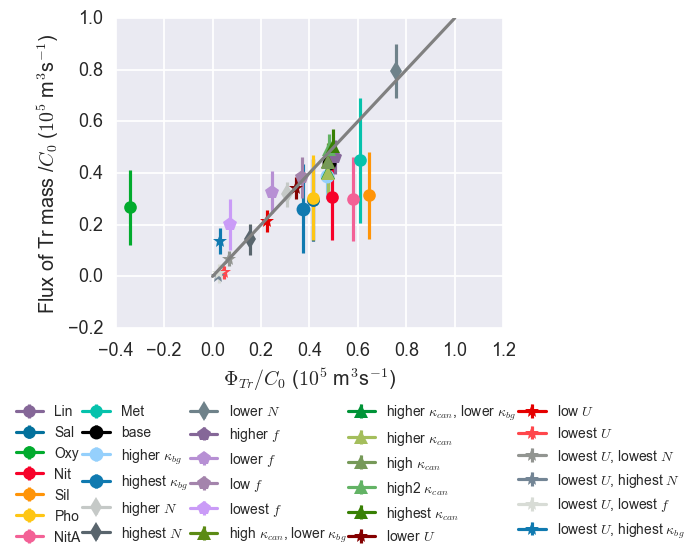

In [45]:
sns.set_context('talk')
colours_Bark = ['dark lavender','ocean blue','kelly green','cherry red','tangerine','golden yellow','medium pink','turquoise']

fig, ax1 = plt.subplots(1,1,figsize=(5,4))

for TrMass, dTr0, Co,C, lab, col in zip(Mass_Bark,Bar_inidTrdz,Bar_TrSB,Bar_maxTr,labels_Bark,colours_Bark):
    
    scaPhiTr, CC = scale_PhiTr(dTr0, Co, Hs, f, U, R, L, No, t, kv, kbg, Hh, Hr, W )
    modPhiTr, PhiTr_std = model_PhiTr(dfBAR[TrMass], times)
    
    ax1.errorbar(scaPhiTr/(1E5*Co), modPhiTr/(1E5*Co), yerr=PhiTr_std/(1E5*Co),
                 color=sns.xkcd_rgb[col], label=lab, marker='o')
    
    err_phi = scaPhiTr/modPhiTr
    
    
for rec,recNoC in zip(records,recordsNoC):    
    
    
    modPhiTr, modPhiTr_std = model_PhiTr(rec.TrMass, times)
    scaPhiTr, CC = scale_PhiTr(rec.inidTrdz, rec.TrSB, Hs, rec.f, rec.u_mod, R, L, rec.N, t, rec.kv, rec.kbg, Hh, Hr, W )
     
    ax1.errorbar(scaPhiTr/(1E5*rec.TrSB), modPhiTr/(1E5*rec.TrSB),
                 yerr=modPhiTr_std/(1E5*rec.TrSB), 
                 color=sns.xkcd_rgb[rec.color2],
                 label=rec.label,
                 marker=rec.mstyle, markersize = 10)
    
    err_phi = scaPhiTr/modPhiTr    
    
ax1.set_ylabel('Flux of Tr mass /$C_0$ ($10^5$ m$^3$s$^{-1}$)')
ax1.set_xlabel('$\Phi_{Tr}/C_0$ ($10^5$ m$^3$s$^{-1}$)')
ax1.legend(bbox_to_anchor=(1.5,-0.2),ncol=5, columnspacing=0.1, fontsize=10)
ax1.plot(np.linspace(0,1,20),np.linspace(0,1,20), color='0.5')

fig.savefig('Phi_tr_scaling_all_runs.eps', format='eps',bbox_inches='tight')


##### 